In [2]:
import mesa
import math
import numpy as np
from model import Evacuation
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [3]:
sns.set_theme(style = "whitegrid", palette = "Pastel1")

# BNE mixed RF

## przykładowa symulacja

W folderze Wyniki IV nagrania symulacji:
- empty BNE, RF i 50/50
- two blocks BNE, RF i 50/50

Można je przyspieszyć i wstawić na prezentację, żeby było szybciej i łatwiej niż pokazywanie na żywo symulacji, ustawiłam też to samo seed, żeby byli ustawieni tak samo początkowo dla różnych algorytmów dzięki czemu bardziej porównywalne

## contour plot

czas ewakuacji vs liczba agentów i %BNE

In [4]:
def run_experiment(agent_counts, bne_percentages, map_type, iters=50, save_path="experiment_results.csv"):
    if os.path.exists(save_path):
        results_df = pd.read_csv(save_path)
    else:
        results_df = pd.DataFrame(columns=["n", "p_BNE", "mean_time"])

    existing_rows = {(int(row["n"]), int(row["p_BNE"])) for _, row in results_df.iterrows()}

    for n_agents in agent_counts:
        for p_bne in bne_percentages:
            if (n_agents, p_bne) in existing_rows:
                continue

            params = {
                "n": n_agents,
                "width": 20,
                "height": 10,
                "door_width": 4,
                "seed": None,
                "model_type": "BNE_mixed_RF",
                "p_BNE": p_bne,
                "map_type": map_type,
                "spawn_position": "all",
                "right_door": True
            }

            output = mesa.batch_run(
                Evacuation,
                parameters=params,
                iterations=iters,
                max_steps=300,
                number_processes=10,
                data_collection_period=-1,
                display_progress=False
            )

            df = pd.DataFrame(output)
            mean_time = df.groupby("RunId").first()["Step"].mean()

            new_row = {
                "n": n_agents,
                "p_BNE": p_bne,
                "mean_time": mean_time
            }

            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
            results_df.to_csv(save_path, index=False)

    return results_df


In [19]:
agent_counts = np.arange(100, 500, 15)
bne_percentages = np.arange(0, 101, 10)

In [5]:
def contour_map(results_df):
    pivot_table = results_df.pivot(index="n", columns="p_BNE", values="mean_time")

    min_val = np.nanmin(pivot_table.values)
    max_val = np.nanmax(pivot_table.values)
    levels = np.linspace(min_val, max_val, 10)  # np. 8 przedziałów

    plt.figure(figsize=(10, 7))
    contour = plt.contourf(
        pivot_table.columns,
        pivot_table.index,
        pivot_table.values,
        levels=levels,
        cmap="rocket_r"
    )
    plt.colorbar(contour, label="Mean Exit Time")
    plt.xlabel("Percentage of BNE users")
    plt.ylabel("Number of Agents")
    plt.tight_layout()
    plt.show()


## empty

In [ ]:
results_df_empty = run_experiment(agent_counts, bne_percentages, "empty", iters=50, save_path="empty_results.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_24396\2923671054.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


KeyboardInterrupt: 

In [ ]:
contour_map(results_df_empty)

NameError: name 'results_df_empty' is not defined

## two blocks

In [23]:
results_df_twoblocks = run_experiment(agent_counts, bne_percentages, "two_blocks", iters=50, save_path="two_blocks_results.csv")

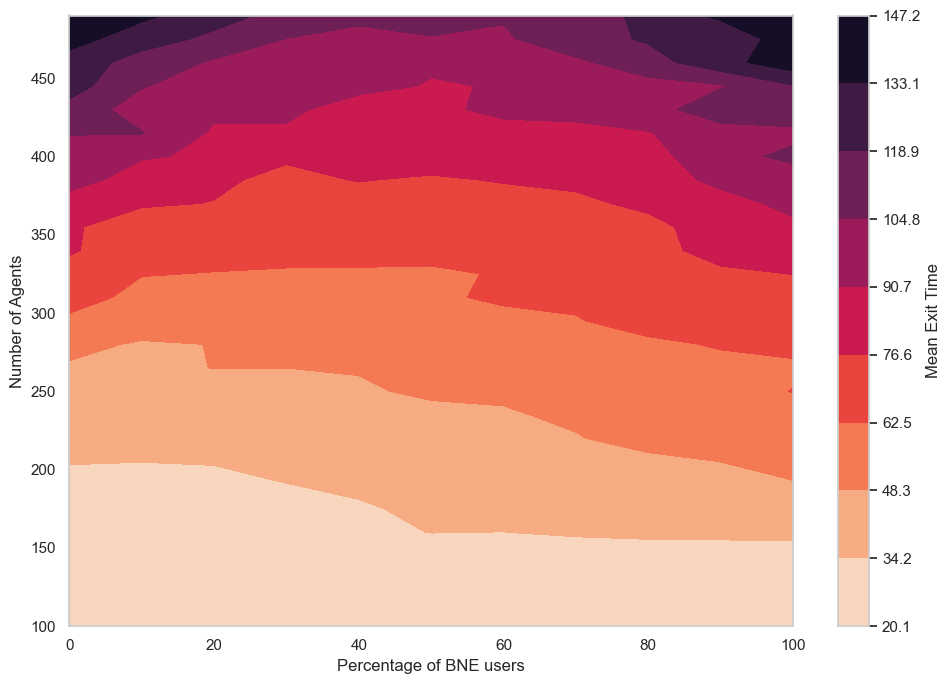

In [26]:
contour_map(results_df_twoblocks)

# Analiza pomieszczenia

Zmiana liczby drzwi (po jednej lub po dwóch stronach)

In [6]:
#porównanie czasów z 1 i 2 door dla różnej liczby agentów w ustalonym pomieszczeniu
def run_two_doors_experiment(agent_counts, iters=50, save_path="two_doors_results.csv"):
    if os.path.exists(save_path):
        results_df = pd.read_csv(save_path)
    else:
        results_df = pd.DataFrame(columns=["n", "door", "mean_time"])

    existing_rows = {(int(row["n"]), row["door"]) for _, row in results_df.iterrows()}

    for n_agents in agent_counts:
        for door in [True, False]:
            if (n_agents, door) in existing_rows:
                continue

            params = {
                "n": n_agents,
                "width": 20,
                "height": 10,
                "door_width": 4,
                "seed": None,
                "model_type": "BNE_mixed_RF",
                "p_BNE": 50,
                "map_type": "empty",
                "spawn_position": "all",
                "right_door": door
            }

            output = mesa.batch_run(
                Evacuation,
                parameters=params,
                iterations=iters,
                max_steps=300,
                number_processes=10,
                data_collection_period=-1,
                display_progress=False
            )

            df = pd.DataFrame(output)
            mean_time = df.groupby("RunId").first()["Step"].mean()

            new_row = {
                "n": n_agents,
                "door": door,
                "mean_time": mean_time
            }

            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
            results_df.to_csv(save_path, index=False)

    return results_df


In [9]:
agent_counts = np.arange(100, 500, 15)
two_doors_df = run_two_doors_experiment(agent_counts)

Text(0.5, 0, 'n (liczba agentów)')

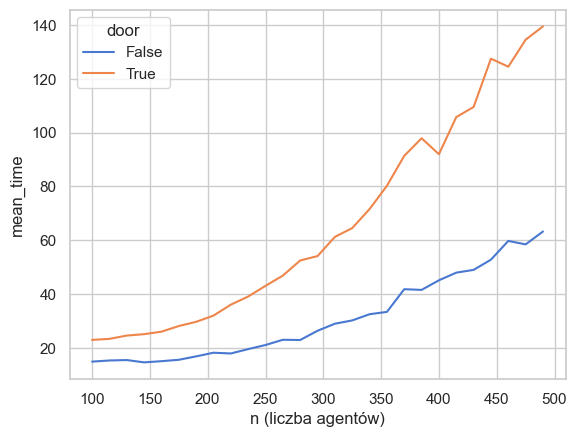

In [10]:
sns.lineplot(data = two_doors_df, x = "n", y="mean_time", hue = "door", palette="muted" )
#plt.title("n: N , width: 40, height: 20, door_width: 6")
plt.xlabel("n (liczba agentów)")

Zmiana szerokości drzwi

Zmiana liczby drzwi (po jednej stronie) - trochę trudniej trzeba zmienić w modelu tworzenie drzwi

# Przykład z salą

stworzenie mniej więcej naszej sali z seminarium i porównanie czasu ewakuacji przy 1 i 2 drzwi dla różnych szerokości drzwi

In [ ]:
def run_door_width_experiment(agent_counts, door_widths, map_type, iters=50, save_path="door_width_results.csv"):

    if os.path.exists(save_path):
        results_df = pd.read_csv(save_path)
    else:
        results_df = pd.DataFrame(columns=["n", "door", "door_width", "mean_time"])


    existing_rows = {(int(row["n"]), row["door"], row["door_width"]) for _, row in results_df.iterrows()}

    for n_agents in agent_counts:
        for door in [True, False]:
            for width in door_widths:
                width = int(width)  

                if (n_agents, door, width) in existing_rows:
                    continue

                params = {
                    "n": n_agents,
                    "width": 20,
                    "height": 10,
                    "door_width": width,
                    "seed": None,
                    "model_type": "BNE_mixed_RF",
                    "p_BNE": 50,
                    "map_type": map_type,
                    "spawn_position": "all",
                    "right_door": door
                }

                output = mesa.batch_run(
                    Evacuation,
                    parameters=params,
                    iterations=iters,
                    max_steps=300,
                    number_processes=10,
                    data_collection_period=-1,
                    display_progress=False
                )

                df = pd.DataFrame(output)
                mean_time = df.groupby("RunId").first()["Step"].mean()

                new_row = {
                    "n": n_agents,
                    "door": door,
                    "door_width": width,
                    "mean_time": mean_time
                }

                results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
                results_df.to_csv(save_path, index=False)

    return results_df

In [35]:
agent_counts = np.arange(100, 130, 10)
door_width=np.arange(2, 4, 2)

door_width_df = run_door_width_experiment(agent_counts, door_width, "empty")

Text(0.5, 1.0, 'Number of doors: 1')

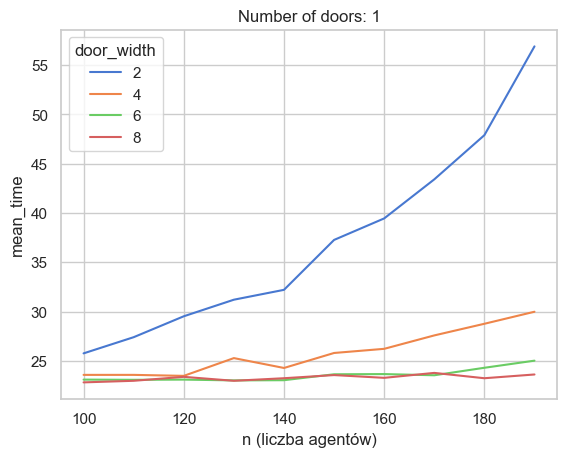

In [36]:
sns.lineplot(data=door_width_df[door_width_df["door"] == True], x="n", y="mean_time", hue="door_width", palette="muted")
plt.xlabel("n (liczba agentów)")
plt.title("Number of doors: 1")

Text(0.5, 1.0, 'Number of doors: 2')

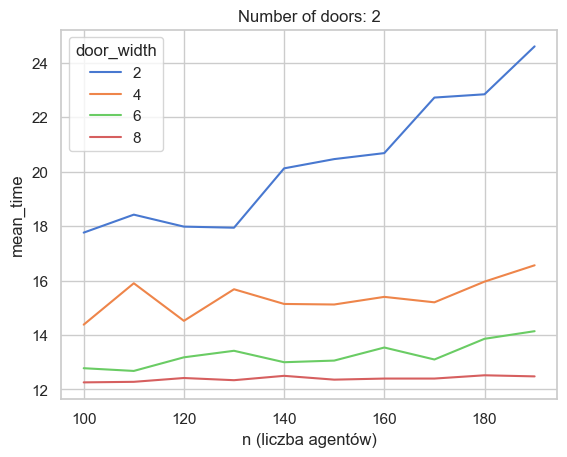

In [37]:
sns.lineplot(data=door_width_df[door_width_df["door"] == False], x="n", y="mean_time", hue="door_width", palette="muted")
plt.xlabel("n (liczba agentów)")
plt.title("Number of doors: 2")